In [137]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing.data import QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p

from sklearn.linear_model import ElasticNet, Lasso, LassoLars,  BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
#import xgboost as xgb
#import lightgbm as lgb
project_dir = 'C:\\Users\\PLDD\\python\\Python\\ML\\Kaggle\\house_price'
raw_path = os.path.join(project_dir,'data','raw')
train_path = os.path.join(raw_path, 'train.csv')
test_path = os.path.join(raw_path, 'test.csv')
sns.set()

In [139]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
test['SalePrice'] = 0.0
df = train.append(test)

In [ ]:
f1 = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF',
     'TotalBsmtSF','BsmtFullBath','BsmtHalfBath']
f2 = ['GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond']
#GarageType (Garage location) - has type Basment investigate how it correlates with basment category.
f3 = ['GarageYrBlt','MoSold','YrSold','YearBuilt','YearRemodAdd']

In [164]:
flds = ['YearBuilt','YearRemodAdd','YrSold','MoSold','GarageYrBlt','GarageType','GarageArea']
f = df[flds]

In [165]:
f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 7 columns):
YearBuilt       2919 non-null int64
YearRemodAdd    2919 non-null int64
YrSold          2919 non-null int64
MoSold          2919 non-null int64
GarageYrBlt     2760 non-null float64
GarageType      2762 non-null object
GarageArea      2918 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 182.4+ KB


In [166]:
lx = f['GarageArea'] == 0.0
f.loc[lx,:] = 0
f.info()


C:\Users\PLDD\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 7 columns):
YearBuilt       2919 non-null int64
YearRemodAdd    2919 non-null int64
YrSold          2919 non-null int64
MoSold          2919 non-null int64
GarageYrBlt     2917 non-null float64
GarageType      2919 non-null object
GarageArea      2918 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 182.4+ KB


In [155]:
x1 = f['YrSold'] - f['YearRemodAdd']
x2 = f['YrSold'] - f['YearBuilt']
g = pd.DataFrame()
g['a'] = x1
g['b'] = x2
g.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 2 columns):
a    2919 non-null int64
b    2919 non-null int64
dtypes: int64(2)
memory usage: 68.4 KB


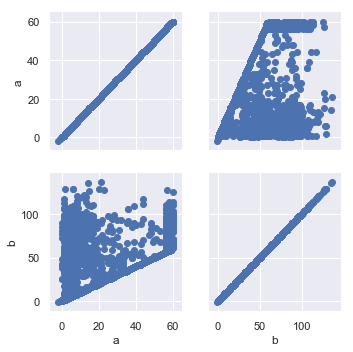

In [160]:
sns.PairGrid(g).map(plt.scatter)

In [163]:
class BaseTransformer:
    def fit(self, X, y):
        return self
## ['YearBuilt','YearRemodAdd','YrSold','MoSold','GarageYrBlt','GarageArea']

class Transformer1(BaseTransformer):
    def __init__(self, akeyfld, avalue):
        self.keyfld = akeyfld
        self.value = avalue
    def Transform(self, X):
        flds = list(set(X.columns) - set(keyfld))
        lx = (X[keyfld] == 0) & (X[flds].isnull().any(axis = 1))
        X.loc[lx,flds] = X[lx][flds].fillna(value = value)
        

In [15]:
class HousePrice:
    train = 0
    test = 1
    def __init__(self, train_path, test_path):
        train = pd.read_csv(train_path)
        train['Id'] = train
        test = pd.read_csv(test_path)
        test[['SalePrice', 'Id']] = (0.0, test)
        self.mlsets = pd.concat([train, test],ignore_index = True) 
        self.trainlx = self.mlsets['Id'] == train
        self.testlx = self.mlsets['Id'] == test
        
#################### Treat Nan values #############################################################
    def __garage_basement_common_nan_handle(self, akeyfld, aflds, avalue):
        lx = (self.mlsets[akeyfld] == 0) & (self.mlsets[aflds].isnull().any(axis = 1))
        self.mlsets.loc[lx,aflds] = self.mlsets[lx][aflds].fillna(value = avalue)
            
    def __garage_nan_handle(self):
        lx = self.mlsets['GarageYrBlt'].isnull()
        self.mlsets.loc[lx,'GarageYrBlt'] = self.mlsets[lx]['YearRemodAdd']
        lx = self.mlsets['GarageCars'].isnull()
        self.mlsets.loc[lx,'GarageCars'] = self.mlsets[~lx]['GarageCars'].mean()
        lx = self.mlsets['GarageArea'].isnull()
        self.mlsets.loc[lx,'GarageArea'] = self.mlsets[~lx]['GarageArea'].median()
        self.__garage_basement_common_nan_handle('GarageArea', ['GarageType','GarageFinish','GarageQual','GarageCond'], 'None')
        self.__garage_basement_common_nan_handle('GarageArea', ['GarageYrBlt','GarageCars'], 0)
        
    def __basement_nan_handle(self):
        df = self.mlsets
        numflds = ['BsmtFinSF1', 'BsmtFinSF2']
        catflds = ['BsmtFinType1','BsmtFinType2']
        for (catfld, numfld) in zip(catflds,numflds):
            lx = [numfld].isnull()
            tmp = df.groupby([catfld])[numfld].describe()
            df.loc[lx,numfld] = np.sum(tmp['50%'] * tmp['count'] / tmp['count'].sum())   
        fld = 'TotalBsmtSF'
        lx = df[fld].isnull()
        df.loc[lx,fld] = df[lx][['BsmtFinSF1', 'BsmtFinSF2']].sum(axis = 1)
        fld = 'BsmtUnfSF'
        lx = df[fld].isnull()
        df.loc[lx,fld] = df[lx]['TotalBsmtSF'] - df[lx][['BsmtFinSF1', 'BsmtFinSF2']].sum(axis = 1)
        flds = ['BsmtFullBath','BsmtHalfBath'] 
        lx = df['BsmtFullBath'].isnull()
        df.loc[lx,['BsmtFullBath','BsmtHalfBath']]= df[~lx][['BsmtFullBath','BsmtHalfBath']].mean(axis = 0).values  
        self.__garage_basement_common_nan_handle('TotalBsmtSF', ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'], 'None')
        self.__garage_basement_common_nan_handle('TotalBsmtSF', ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath'], 0)

    def __from_nan_to_None(self):
        col = ['FireplaceQu','Alley','PoolQC','Fence','MiscFeature']
        self.mlsets[col] = test[col].fillna(value = 'None')
        
    def __MasVnrArea_nan_handle(self):
        df = self.mlsets
        lx = (df['MasVnrArea'] != 0) & (df['MasVnrType'] == 'None')
        df.loc[lx,'MasVnrArea'] = 0.0
        lx = (df['MasVnrArea'] == 0) & (df['MasVnrType'] != 'None')
        df.loc[lx,'MasVnrType'] = 'None'
        lx = df['MasVnrArea'].isnull()
        tmp = df.groupby(['MasVnrType'])['MasVnrArea'].describe()
        df.loc[lx,'MasVnrArea'] = np.sum(tmp['50%'] * tmp['count'] / tmp['count'].sum()) 
    
    def __find_regresion(self,df,fld):
    scaler = QuantileTransformer()
    param_grid = {'alpha': [1e0,0.5, 0.1, 1e-2, 1e-3,1e-4,1e-5,1e-6],'gamma': np.logspace(-4, 2, 14)}
    solver = GridSearchCV(KernelRidge(kernel = 'rbf'), cv=5, param_grid=param_grid)
    #solver = linear_model.RidgeCV(alphas = np.arange(0.001, 5, 0.001))
    
    #param_grid = {'alpha': [5.0,3.0,2.0,1.5,1.3,1.2,1.1,1e0,0.8,0.5,0.2,0.1, 1e-2, 1e-3,1e-4,1e-5,1e-6,1e-7]}
    #solver = GridSearchCV(Ridge(max_iter = 10000,tol = 0.00001), cv=5,param_grid=param_grid)
    #scaler_x = RobustScaler() #make_pipeline(RobustScaler(),PowerTransformer())
    #scaler_y = PowerTransformer()
    scaler_x = QuantileTransformer() 
    
    df = pd.get_dummies(df)
    lx = df[fld].isnull()
    dfy = df[fld]
    dfx = df.drop(fld, axis = 1)
    X = dfx[~lx].as_matrix().astype('float')
    y = dfy[~lx].ravel()
    #scaler_y = scaler_y.fit(y.reshape(-1,1))
    #y = scaler_y.transform(y.reshape(-1,1)).ravel()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    scaler_x = scaler_x.fit(X_train)
    X_train = scaler_x.transform(X_train)
    X_test = scaler_x.transform(X_test)

    solver.fit(X_train, y_train)
    print(solver.score(X_test, y_test))
    X = scaler_x.fit_transform(X)
    XX = scaler_x.transform(dfx[lx].as_matrix().astype('float'))
    solver.fit(X, y) 
    yy = solver.predict(XX).astype('float')
    dfy[lx] = yy#scaler_y.inverse_transform(yy.reshape(-1,1)).ravel()
    return dfy

  
        


In [29]:
def GetTrainTestSets(train_path, test_path):   
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    col = ['FireplaceQu','Alley','PoolQC','Fence','MiscFeature']
    train[col] = train[col].fillna(value = 'None')
    test[col] = test[col].fillna(value = 'None')
    
    catcol = [['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'],
              ['GarageType','GarageFinish','GarageQual','GarageCond']]
    numcol = [['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath'],
              ['GarageYrBlt','GarageCars','GarageArea']]
    keyflds = ['TotalBsmtSF','GarageArea']
    for (catflds,numflds,keyfld) in zip(catcol, numcol, keyflds):
        
        lx = (train[keyfld] == 0) & (train[catflds].isnull().any(axis = 1))
        train.loc[lx,catflds] = train[lx][catflds].fillna(value = 'None')
        
        lx = (train[keyfld] == 0) & (train[numflds].isnull().any(axis = 1))
        train.loc[lx,numflds] = train[lx][numflds].fillna(value = 0)
        
        lx = (test[keyfld] == 0) & (test[catflds].isnull().any(axis = 1))
        test.loc[lx,catflds] = test[lx][catflds].fillna(value = 'None')
        
        lx = (test[keyfld] == 0) & (test[numflds].isnull().any(axis = 1))
        test.loc[lx,numflds] = test[lx][numflds].fillna(value = 0)
        
    train = train.drop('Utilities', axis = 1)
    test = test.drop('Utilities', axis = 1)
    return (train, test)

In [55]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

In [135]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
g1 = pd.DataFrame({'a' : [1,2,3], 'b' : ['11', '22', '33']})
class Tr(BaseEstimator):
    def fit(self,X,y = None):
        self.columns = X.columns
        return self
    def transform(self, X):
        X[X.columns[0]] += 4
        print(X.head())
        return X
    def fit_transform(self,X,y = None):
        self = self.fit(X)
        return self.transform(X)
    def get_feature_names(self):
        return self.columns
    
column_trans = ColumnTransformer([('a_category', Tr(), ['a']),#Pipeline([('s1' ,Tr()), ('s2',Tr())]), ['a']),
                                  ('b_category', OneHotEncoder(dtype = 'float'), ['b'])],
                                 remainder='drop')



In [136]:
rr = column_trans.fit_transform(g1)
#p = Pipeline([('b', Tr()),('a', column_trans)])
#rr=p.fit_transform(g1)
print(rr)
print(column_trans.get_feature_names())
#g2 = pd.DataFrame(data = rr, columns = column_trans.get_feature_names)
#gg=Tr()
#g1[g1.columns[0]] += 4

   a
0  5
1  6
2  7
[[5. 1. 0. 0.]
 [6. 0. 1. 0.]
 [7. 0. 0. 1.]]
['a_category__a', 'b_category__x0_11.0', 'b_category__x0_22.0', 'b_category__x0_33.0']


C:\Users\PLDD\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [93]:
g1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
a    3 non-null int64
b    3 non-null object
dtypes: int64(1), object(1)
memory usage: 128.0+ bytes


In [73]:
class Base:
    def fff(self):
        print('Base')
class Derivative(Base):
    pass


In [74]:
v = Derivative()
v.fff()

Base


In [30]:
(train, test) = GetTrainTestSets(train_path, test_path)

In [31]:
def ProccessOutliers(train, test):
    lx1 = (train['SalePrice'] <= 200000) & (train['GrLivArea'] >= 4000) 
    lx2 = train['LotFrontage'] > 300 
    lx = lx1 | lx2
    train = train[~lx]
    return (train, test)

In [32]:
def ProcessFeature(train, test):
    #train['SalePrice'] = np.log1p(train['SalePrice'])
    return (train, test)

In [33]:
def FindRegresion(df,fld):
    scaler = QuantileTransformer()
    param_grid = {'alpha': [1e0,0.5, 0.1, 1e-2, 1e-3,1e-4,1e-5,1e-6],'gamma': np.logspace(-4, 2, 14)}
    solver = GridSearchCV(KernelRidge(kernel = 'rbf'), cv=5, param_grid=param_grid)
    #solver = linear_model.RidgeCV(alphas = np.arange(0.001, 5, 0.001))
    
    #param_grid = {'alpha': [5.0,3.0,2.0,1.5,1.3,1.2,1.1,1e0,0.8,0.5,0.2,0.1, 1e-2, 1e-3,1e-4,1e-5,1e-6,1e-7]}
    #solver = GridSearchCV(Ridge(max_iter = 10000,tol = 0.00001), cv=5,param_grid=param_grid)
    #scaler_x = RobustScaler() #make_pipeline(RobustScaler(),PowerTransformer())
    #scaler_y = PowerTransformer()
    scaler_x = QuantileTransformer() 
    
    df = pd.get_dummies(df)
    lx = df[fld].isnull()
    dfy = df[fld]
    dfx = df.drop(fld, axis = 1)
    X = dfx[~lx].as_matrix().astype('float')
    y = dfy[~lx].ravel()
    #scaler_y = scaler_y.fit(y.reshape(-1,1))
    #y = scaler_y.transform(y.reshape(-1,1)).ravel()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
    scaler_x = scaler_x.fit(X_train)
    X_train = scaler_x.transform(X_train)
    X_test = scaler_x.transform(X_test)

    solver.fit(X_train, y_train)
    print(solver.score(X_test, y_test))
    X = scaler_x.fit_transform(X)
    XX = scaler_x.transform(dfx[lx].as_matrix().astype('float'))
    solver.fit(X, y) 
    yy = solver.predict(XX).astype('float')
    dfy[lx] = yy#scaler_y.inverse_transform(yy.reshape(-1,1)).ravel()
    return dfy

In [34]:
def PreprocessAll(df):
    df['MSSubClass'] = df['MSSubClass'].apply(str)
    df['OverallCond'] = df['OverallCond'].astype(str)
    df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    return df

In [35]:
def ProccessNumNans(df):
    fld = 'LotFrontage'
    df.loc[:,[fld]] = FindRegresion(df[['LotFrontage','Neighborhood','LotConfig','LotArea']],fld)
    
    lx = (df['MasVnrArea'] != 0) & (df['MasVnrType'] == 'None')
    df.loc[lx,'MasVnrArea'] = 0.0
    lx = (df['MasVnrArea'] == 0) & (df['MasVnrType'] != 'None')
    df.loc[lx,'MasVnrType'] = 'None'
    
    numflds = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2']
    catflds = ['MasVnrType', 'BsmtFinType1','BsmtFinType2']

    for (catfld, numfld) in zip(catflds,numflds):
        lx = df[numfld].isnull()
        tmp = df.groupby([catfld])[numfld].describe()
        df.loc[lx,numfld] = np.sum(tmp['50%'] * tmp['count'] / tmp['count'].sum())   
        
    fld = 'TotalBsmtSF'
    lx = df[fld].isnull()
    df.loc[lx,fld] = df[lx][['BsmtFinSF1', 'BsmtFinSF2']].sum(axis = 1)
    
    fld = 'BsmtUnfSF'
    lx = df[fld].isnull()
    df.loc[lx,fld] = df[lx]['TotalBsmtSF'] - df[lx][['BsmtFinSF1', 'BsmtFinSF2']].sum(axis = 1)
    
    flds = ['BsmtFullBath','BsmtHalfBath'] 
    lx = df['BsmtFullBath'].isnull()
    df.loc[lx,['BsmtFullBath','BsmtHalfBath']]= df[~lx][['BsmtFullBath','BsmtHalfBath']].mean(axis = 0).values
    
    lx = df['GarageYrBlt'].isnull()
    df.loc[lx,'GarageYrBlt'] = df[lx]['YearRemodAdd']
    lx = df['GarageCars'].isnull()
    df.loc[lx,'GarageCars'] = df[~lx]['GarageCars'].mean()
    lx = df['GarageArea'].isnull()
    df.loc[lx,'GarageArea'] = df[~lx]['GarageArea'].median()
    return df

In [36]:
def ProccessCategoricalNans(df):
    oldflds = []
    newdf = pd.DataFrame()
######################## 1) MSZoning - 'RL', 'RM', 'C (all)', 'FV', 'RH', nan ############################
    colname = 'MSZoning'
    oldflds.append(colname)
    #### with Mitchel neighbor it is highly likely that zoning is 'RL' (grouping by Neighbors + BuiltYear)
    lx=(df[colname].isnull()) & (df['Neighborhood'] == 'Mitchel')  
    df.loc[lx,colname] = 'RL'
    ### group by IDOTRR neighbor
    invalidlx = df[colname].isnull() 
    idotrrlx = df['Neighborhood'] == 'IDOTRR'

    tempdf = pd.get_dummies(df[colname],prefix = colname).astype(float)
    tempdf.loc[invalidlx,:] = tempdf[idotrrlx].sum().values / tempdf[idotrrlx].sum().sum()
    newdf[tempdf.columns] = tempdf
######################## 2) ordered categorias
    catflds = ['FireplaceQu','ExterQual','ExterCond','HeatingQC','PoolQC','LandSlope','LotShape',
               'PavedDrive','Street','Alley','CentralAir','MSSubClass','OverallCond','YrSold','MoSold']
    df['FireplaceQu'] = pd.Categorical(df['FireplaceQu'].values,  ['None','Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['ExterQual'] = pd.Categorical(df['ExterQual'].values, ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['ExterCond'] = pd.Categorical(df['ExterCond'].values, ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['HeatingQC'] = pd.Categorical(df['HeatingQC'].values, ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['PoolQC'] = pd.Categorical(df['PoolQC'].values, ['None', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['LandSlope'] = pd.Categorical(df['LandSlope'].values, ['Sev', 'Mod', 'Gtl'], ordered = True)
    df['LotShape'] = pd.Categorical(df['LotShape'].values, ['Reg', 'IR1', 'IR2', 'IR3'], ordered = True)
    df['PavedDrive'] = pd.Categorical(df['PavedDrive'].values, ['N', 'P', 'Y'], ordered = True)
    df['Street'] = pd.Categorical(df['Street'].values, ['Grvl','Pave'], ordered = True)
    df['Alley'] = pd.Categorical(df['Alley'].values, ['None', 'Grvl', 'Pave'], ordered = True)
    df['CentralAir'] = pd.Categorical(df['CentralAir'].values, ['N', 'Y'], ordered = True)
    df['MSSubClass'] = pd.Categorical(df['MSSubClass'].values, ['20','30','40','45','50','60','70','75','80','85','90','120','150','160','180','190'], ordered = True)
    df['OverallCond'] = pd.Categorical(df['OverallCond'].values, ['1','2','3','4','5','6','7','8','9'], ordered = True)
    df['YrSold'] = pd.Categorical(df['YrSold'].values, ['2006','2007','2008','2009','2010'], ordered = True)
    df['MoSold'] = pd.Categorical(df['MoSold'].values, ['1','2','3','4','5','6','7','8','9','10','11','12'], ordered = True)

    nanflds = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','KitchenQual',
               'GarageFinish', 'GarageQual','GarageCond']
    df['BsmtQual'] = pd.Categorical(df['BsmtQual'].values, ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['BsmtCond'] = pd.Categorical(df['BsmtCond'].values, ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['BsmtExposure'] = pd.Categorical(df['BsmtExposure'].values, ['None', 'No', 'Mn', 'Av', 'Gd'], ordered = True)
    df['BsmtFinType1'] = pd.Categorical(df['BsmtFinType1'].values, ['None','Unf','LwQ', 'Rec','BLQ','ALQ','GLQ'], ordered = True)
    df['BsmtFinType2'] = pd.Categorical(df['BsmtFinType2'].values, ['None','Unf','LwQ', 'Rec','BLQ','ALQ','GLQ'], ordered = True)
    df['KitchenQual'] = pd.Categorical(df['KitchenQual'].values, ['Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['GarageFinish'] = pd.Categorical(df['GarageFinish'].values, ['None', 'Unf', 'RFn', 'Fin'], ordered = True)
    df['GarageQual'] = pd.Categorical(df['GarageQual'].values, ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df['GarageCond'] = pd.Categorical(df['GarageCond'].values, ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], ordered = True)
    df.loc[:,catflds + nanflds] = df[catflds + nanflds].apply(lambda x: x.cat.codes).astype('float')
    for fld in nanflds:
        lx = df[fld] < 0.0
        df.loc[lx,fld] = df[~lx][fld].mean()
######################## 3) 'Exterior1st', 'Exterior2nd','MasVnrType','Electrical','KitchenQual'#############
########################'BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2'##################
######################## 'Functional','GarageType', 'GarageFinish', 'GarageQual','GarageCond'################
######################## 'PoolQC','SaleType'#################################################################   
    catflds = ['Exterior1st','Exterior2nd','MasVnrType','Electrical','GarageType','SaleType','Functional']
    for fld in catflds:
        lx = df[fld].isnull()
        oldflds.append(fld)
        tmp = pd.get_dummies(df[fld],prefix = fld).astype(float)
        tmp.loc[lx,:] = tmp[~lx].sum().values / tmp[~lx].sum().sum()
        newdf[tmp.columns] = tmp
    df = df.drop(labels = oldflds,axis = 1)
    df[newdf.columns] = newdf
    df = pd.get_dummies(df).astype(float)
    return df

In [37]:
def FormatAndSave(df):
    processed_data_path = os.path.join(os.path.pardir,'data','processed')
    write_train_path = os.path.join(processed_data_path, 'train.csv')
    write_test_path = os.path.join(processed_data_path, 'test.csv')
    train_df = df[df['SalePrice'] != 0]
    train_df.loc[:,'Id'] = train_df['Id'].astype('int32').values
    test_df = df[df['SalePrice'] == 0]
    test_df = test_df.drop(labels = 'SalePrice',axis = 1)
    test_df.loc[:,'Id'] = test_df['Id'].astype('int32').values
    train_df.to_csv(write_train_path)
    test_df.to_csv(write_test_path) 
    return (df,train_df,test_df)

In [38]:
def GetResultData(train_path, test_path):
    (train, test) = GetTrainTestSets(train_path, test_path)
    (train, test) = ProccessOutliers(train, test)
    (train, test) = ProcessFeature(train, test)
    train1 = train
    test1 = test
    test['SalePrice'] = 0
    return (train.append(test), train1, test1)

In [39]:
(df, train, test) = GetResultData(train_path, test_path)
#df = ProccessNumNans(df)
(df, train, test) = df.pipe(PreprocessAll).pipe(ProccessNumNans).pipe(ProccessCategoricalNans).pipe(FormatAndSave)
#best score = 0.627

C:\Users\PLDD\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\PLDD\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.5735878919174737


C:\Users\PLDD\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\PLDD\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\PLDD\Anaconda3\lib\site-packages\pandas\core\indexing.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [49]:
import matplotlib as mtl

In [50]:
mtl.matplotlib_fname()

'C:\\Users\\PLDD\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\matplotlibrc'

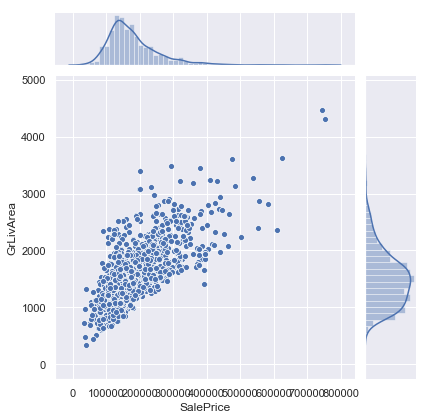

In [132]:
y = train['SalePrice'].values
sns.JointGrid(x = 'SalePrice', y = 'GrLivArea', data=train[['SalePrice','GrLivArea']]).plot(sns.scatterplot, sns.distplot)

In [135]:
train[['SalePrice','GrLivArea']].corr()

,SalePrice,GrLivArea
SalePrice,1.000000,0.734842
GrLivArea,0.734842,1.000000


In [ ]:
flds =['SalePrice','GrLivArea', 'GarageArea', 'LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
#sns.PairGrid(train[flds]).map(plt.scatter)
cor = train.corr()
#sns.distplot(cor['SalePrice'])
cor['SalePrice']

#  Build model

In [326]:
processed_data_path = os.path.join(os.path.pardir,'data','processed')
train_path = os.path.join(processed_data_path, 'train.csv')
test_path = os.path.join(processed_data_path, 'test.csv')
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
test_df = test_df.drop(labels = ['Unnamed: 0'],axis = 1)
train_df = train_df.drop(labels = ['Id','Unnamed: 0'],axis = 1)

In [327]:
def linear_ml_solve(train_df, test_df, scaler, solver, q = 0.4, target = 'temp.csv'):
    collx = train_df.columns != 'SalePrice'
    X = train_df.loc[:,collx ].as_matrix().astype('float')
    y = train_df['SalePrice'].ravel()
    scaler_y = RobustScaler()#PowerTransformer()
    scaler_y = scaler_y.fit(y.reshape(-1,1))
    #y = scaler_y.transform(y.reshape(-1,1))
    y = np.log1p(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=q, random_state=0)
    #scaler = scaler.fit(X_train)
    X_train = scaler.fit_transform(X_train)
    sscore = 0.0
    if q != 0:
        X_test = scaler.transform(X_test)
        solver.fit(X_train, y_train)
        sscore = solver.score(X_test, y_test)
    else: 
        print("No test subsets!!!!")
    scaler = scaler.fit(X) 
    X = scaler.transform(X)  
    ids = test_df['Id'].values
    test_df = test_df.drop(labels = 'Id',axis = 1)
    XX = scaler.transform(test_df.as_matrix().astype('float'))
    solver.fit(X, y) 
    pred_y = solver.predict(XX).astype('float')
    df_submission = pd.DataFrame({'Id': ids, 'SalePrice' : np.exp(pred_y) - 1.0} )
    #df_submission = pd.DataFrame({'Id': ids, 'SalePrice' : scaler_y.inverse_transform(pred_y.reshape(-1,1)).ravel()} )
    submission_data_path = os.path.join(os.path.pardir,'data','external')
    submission_file_path = os.path.join(submission_data_path, target)
    df_submission.to_csv(submission_file_path, index=False)
    print(sscore)
    return (df_submission, solver, sscore) 

In [328]:
#Validation function
def rmsle_cv(model):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# Preprocessing Scaling

In [329]:
scaler1 = StandardScaler()
scaler2 = MinMaxScaler()
scaler3 = RobustScaler()
scaler4 = Normalizer()
scaler5 = QuantileTransformer()
scaler6 = PowerTransformer()
scaler7 = make_pipeline(RobustScaler(), PowerTransformer())

# ML

In [282]:
#Ridge Linear Regresion
param_grid = {'alpha': [7.0,6.0,5.0,3.0,2.0,1.5,1.3,1.2,1.1,1.001,0.8,0.5,0.2,0.1, 1e-2, 1e-3,1e-4,1e-5,1e-6,1e-7]}
solver = GridSearchCV(Ridge(max_iter = 10000,tol = 0.00001), cv=5,param_grid=param_grid)
scaler = RobustScaler()
(ridgedm, ridgesolver, ridgescore) = linear_ml_solve(train_df, test_df, scaler, solver, 0.4,'Ridged.csv')
print(ridgesolver.best_params_)
print(ridgesolver.best_score_)
#max score = 0.9158041549014316

C:\Users\PLDD\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.9156653808926848
{'alpha': 7.0}
0.9163517290520821


C:\Users\PLDD\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [332]:
#Lasso Linear Regresion
#param_grid = {'alpha': [5.0,3.0,2.0,1.5,1.3,1.2,1.1,1e0,0.8,0.5,0.2,0.1, 1e-2,0.05,1e-3,0.005, 1e-4,0.0005, 1e-5,0.000051e-6,1e-7]}
param_grid = {'alpha': [ 0.04,0.03, 0.02,0.001, 0.000888889, 0.0008]}
solver = GridSearchCV(Lasso(max_iter = 25000,tol = 0.000001), cv=5,param_grid=param_grid)
solver = Lasso(max_iter = 25000,tol = 0.000001, alpha = 0.000888889)
scaler = RobustScaler()
(lassom, lassomsolver, lassomscore) = linear_ml_solve(train_df, test_df, scaler, solver, 0.4,'Lasso.csv')
#print(lassomsolver.best_params_)
#print(lassomsolver.best_score_)
#max score = 0.9183107282670468
#0.00089 0.9183148121017135
#0.000889 0.9183151760580683
#alpha = 0.000888889 score = 0.9183152160821689

0.9183152160821689


In [341]:
#LassoLARS Linear Regresion
param_grid = {'alpha': [5.0,3.0,2.0,1.5,1.3,1.2,1.1,1e0,0.8,0.5,0.2,0.1, 1e-2,0.05,1e-3,0.005, 1e-4,0.0005, 1e-5,0.000051e-6,1e-7]}
param_grid = {'alpha': [0.001, 0.00088888]}
solver = GridSearchCV(Lasso(max_iter = 25000,tol = 0.000001), cv=5,param_grid=param_grid)
#solver = LassoLars(max_iter = 25000,alpha = 0.00088888)
scaler = RobustScaler()
(lassolarsm, lassolarsmsolver, lassolarsmscore) = linear_ml_solve(train_df, test_df, scaler, solver, 0.4,'LassoLars.csv')
print(lassolarsmsolver.best_params_)
print(lassolarsmsolver.best_score_)

0.9183152193227974
{'alpha': 0.00088888}
0.9193322693422967


In [ ]:
#LassoLarsIC Linear Regresion
solver = LassoLarsIC(max_iter = 25000, criterion = 'aic')
scaler = RobustScaler()
lassolarsICm = linear_ml_solve(train_df, test_df, scaler, solver, 0.4,'LassoLarsIC.csv')
#max score = 0.8964009621989726

In [ ]:
[x for x in np.logspace(start = 0.0001, stop = 0.99, num=100)]

In [ ]:
#ElasticNet Regresion
param_grid = {'alpha': [5.0,3.0,2.0,1.5,1.3,1.2,1.1,1e0,0.99,0.9,0.8,0.6,0.5,0.4,0.3,0.25,0.2,0.1, 1e-2,0.05,1e-3,0.005, 1e-4,0.0005, 1e-5,0.000051e-6,1e-7],
             'l1_ratio' : [1e-3,5e-3,1e-2,5e-2,0.1,0.2,0.25,0.3,0.4,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.901,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,0.995,0.999]}
solver = GridSearchCV(ElasticNet(max_iter = 25000,tol = 0.00001), cv=5,param_grid=param_grid)
print(solver.estimator.alpha)
scaler = RobustScaler()
elastic_net_m = linear_ml_solve(train_df, test_df, scaler, solver, 0.4,'ElasticNet.csv')
#max_score = 0.9183288770325282

In [ ]:
solver1 = linear_model.RidgeCV(alphas = np.arange(0.001, 5, 0.001))
solver2 = linear_model.LassoCV()
solver3 = linear_model.ElasticNetCV(alphas = np.arange(0.001, 5, 0.001), max_iter = 20000 )
solver4 = linear_model.BayesianRidge()
solver6 = linear_model.PassiveAggressiveRegressor(C = 10,tol = 0.00001, max_iter = 50000)
solver7 = linear_model.HuberRegressor(max_iter=10000)
solver8 = Pipeline([('poly', PolynomialFeatures(degree=2)),  ('linear', solver1)])

param_grid = {
    'alpha': [1e0,0.5, 0.1, 1e-2, 1e-3,1e-4,1e-5,1e-6],
    'gamma': np.logspace(-4, 2, 14)
}
solver5_1 = GridSearchCV(KernelRidge(kernel = 'polynomial',degree = 80), cv=8, param_grid=param_grid)
solver5_2 = GridSearchCV(KernelRidge(kernel = 'rbf'), cv=8, param_grid=param_grid)

In [ ]:

subm = linear_ml_solve(train_df, test_df, scaler5, solver2, 0.4,'11_LassoCV.csv')